(Chap_SciPy)=
# SciPy: Root finding, minimizing, interpolation

This chapter was coauthored by Jason DeBacker and Richard W. Evans.

SciPy is Python's primary scientific computing package.[^SciPy] As described in the {ref}`Chap_NumPy` chapter, SciPy is built with NumPy as a core dependency. The SciPy website [homepage](https://scipy.org/) states that, "SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems."

The `OG-Core` model and its country calibrations use SciPy primarily for three functionalities, although there are some other smaller use cases.
* Finding the roots or zeros of functions ([`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html))
* Solving minimization problem ([`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html))
* Interpolation ([`scipy.interpolate`](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html))


(SecSciPyRoot)=
## Root finding


(SecSciPyRoot_theory)=
### Root finding theory

Root finding is equivalent to finding the solution to a system of equations. For example, observe the following quadratic equation.
```{math}
  :label: EqSciPy_UnivarNonZeroFunc
  ax^2 + bx + c = 12
```
We can always restate that equation as a function that equals zero.
```{math}
  :label: EqSciPy_UnivarZeroFunc
  ax^2 + bx + c - 12 = 0
```

Let $f(x)$ be a vector of functions $f_r(x)$, each of which is a function of a vector of variables $x\equiv\left[x_1,x_2,...x_K\right]$. Without loss of generality, we can specify an arbitrary number of functions $f(x)$ as an equation equal to zero.
```{math}
  :label: EqSciPy_ZeroFunc
  f(x)=0 \quad\text{or}\quad
    \begin{bmatrix}
      f_1(x) \\
      f_2(x) \\
      \vdots \\
      f_R(x) \\
    \end{bmatrix} =
    \begin{bmatrix}
      0 \\
      0 \\
      \vdots \\
      0
    \end{bmatrix}
```
Examples of systems that fit this representation in {eq}`EqSciPy_ZeroFunc` include single equations like {eq}`EqSciPy_UnivarNonZeroFunc` and {eq}`EqSciPy_UnivarZeroFunc`, systems of linear equations, univariate and multivariate equations, and systems of nonlinear equations.

```{prf:definition} System Rank
:label: DefSciPy_SysRank

The **system rank** $R^*$ for the system of $R$ equations $f(x)$ with $K$ variables $x=[x_1, x_2,...x_K]$ is the number of equations in $f:\mathbb{R}^K\rightarrow\mathbb{R}^R$ that are independent of each other, such that $R^*\leq R$, where independence of two equations is defined as:
\begin{equation*}
  f_r(x) \neq f_s(x) \quad\forall r\neq s
\end{equation*}
```

As an example of system rank in {prf:ref}`DefSciPy_SysRank`, the following system of equations has three equations $R=3$ but only has rank two $R^*=2$ because the first equation is equal to the second equation. The first equation is simply two times the first equation. The second equation gives no unique information once we know the first equation. Only two equations in this system give unique information.
\begin{equation*}
  \begin{split}
    3x + y +10z = 0.5 \\
    6x + 2y + 20z = 1 \\
    x + y - z = 7
  \end{split}
\end{equation*}

System rank of $R^*<R$ can also occur when two equations are nonlinear combinations of each other. The following system of two equations $R=2$ only has system rank $R^*=1$ because the second equation is just the square of the first equation. Again, the second equation gives no unique information once we know the first equation.
\begin{equation*}
  \begin{split}
    x + y = 0 \\
    x^2 + 2xy + y^2 = 0
  \end{split}
\end{equation*}

```{prf:definition} Identification
:label: DefSciPy_Identif

A system of equations $f(x)$ with $K$ variables $x=[x_1, x_2,...x_K]$ and $R^*$ independent equations is characterized as:
* **identified** if the number of independent equations is at least as large as the number of variables $R^*\geq K$
* **exactly identified** if the number of independent equations exactly equals the number of variables $R^*=K$
* **over identified** if the number of independent equations is strictly greater than the number of variables $R^*>K$
* **under identified** if the number of independent equations is strictly less than the number of variables $R^*<K$
```

Many systems of equations that occur in theoretical models are *exactly identified* as defined in {prf:ref}`DefSciPy_Identif`. The easiest way to solve exactly identified systems of linear equations---systems in which each function $f_i(x)$ is a linear function of the vector of $x$ variables---is often matrix inversion. When the system of equations $f(x)$ is nonlinear, finding the solution takes more advanced methods.[^SciPyJuddMethods]

It is *not* widely recognized among researchers that even in systems of equations for which existence and uniqueness of the solution can be proven, no root finding algorithm with finite computational power exists that guarantees convergence to the solution of the system in every case. Judd states:

> Nonlinear equation solving presents problems not present with linear equations or optimization. In particular, the existence problem is much more difficult for nonlinear systems. Unless one has an existence proof in hand, a programmer must keep in mind that the absence of a solution may explain a program's failure to converge. Even if there exists a solution, all methods will do poorly if the problem is poorly conditioned near a solution. Transforming the problem will often improve performance.{cite}`Judd:1998` (p. 192)

Because root finding in nonlinear systems can be so difficult, much research into the best methods has accumulated over the years. And the approaches to solving nonlinear systems can be an art as much as a science. This is also true of minimization problems discussed in the next section ({ref}`SecSciPyMin`). For this reason, the [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) module has many different solution algorithms you can use to find the solution to a nonlinear system of equations (e.g., `hybr`, `lm`, `linearmixing`).

All of the root finder methods in [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) are iterative. They take an initial guess for the solution for the variable vector $x_i$, evaluate the functions $f(x_i)$ in {eq}`EqSciPy_ZeroFuncErr` at $x_i$, and guess a new value for the solution vector $x_{i+1}$ until the errors on the left-hand-side of the functions in {eq}`EqSciPy_ZeroFuncErr` get arbitrarily close to zero.
```{math}
  :label: EqSciPy_ZeroFuncErr
  \hat{x} = x:\quad
    \begin{bmatrix}
      f_1(x) \\
      f_2(x) \\
      \vdots \\
      f_R(x) \\
    \end{bmatrix} =
    \begin{bmatrix}
      \varepsilon_1 \\
      \varepsilon_2 \\
      \vdots \\
      \varepsilon_R
    \end{bmatrix} \quad\text{and}\quad
    || \left[\varepsilon_1, \varepsilon_2,...\varepsilon_R\right] || \leq \text{toler}
```


Before we go through some root finding examples using [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html), we want to share some root finding wisdom in the following {prf:ref}`ObsSciPy_RootMinWisdom` that we have learned over the years. The wisdom in this definition also applies to minimization problems discussed in the following section.

```{prf:observation} Root finding and minimization problem wisdom
:label: ObsSciPy_RootMinWisdom

The following strategies for successfully finding the solution to systems of equations or finding the global minimum of an optimization problem come from long experience working with these problems.
1. Knowing and debugging the **underlying model theory** is often more effective and more important than finding the best, most advanced, or most robust root finder or minimizer. In most instances in which our optimizers have given non solutions or incorrect solutions, the adjustment that fixed the problem was most often going back to the underlying system of equations and understanding what they mean.
2. Choose an **intelligent initial guess**. Many optimization algorithms require an initial guess as an input. When the underlying system of equations or criterion function is highly nonlinear, a good initial guess is critical for the root finder or minimizer to converge. The theory or the underlying data often suggest a reasonable initial guess. In dynamic models, the steady-state or the previous period's solution might be a good initial guess.
3. Give the root finder or minimizer **as much information as possible** about the problem. Many root finders and minimizers can take as inputs contraints on the solution and theoretical derivatives. These save the algorithm computational calories and may engage components of the algorithm that are specifically designed to use those details.
```


(SecSciPyRoot_examp)=
### Root finding examples


(SecSciPyRoot_examp1)=
#### Simple numerical example

Assume that the system of equations we are trying to solve is a two-equation system $R=2$ of nonlinear independent equations in two variables $x$ and $y$.

```{math}
  :label: EqSciPyRootEx1a

  x^2 - 4x + 5 - y = 0
```
```{math}
  :label: EqSciPyRootEx1b

  e^x - y = 0
```

By plotting these two equations in {numref}`Figure %s <FigScipyRoot_examp1>`, we can see that there is only one solution. And just by looking at the plot, we can see that the solution is close to $(\hat{x},\hat{y})\approx (0.9, 2.2)$.

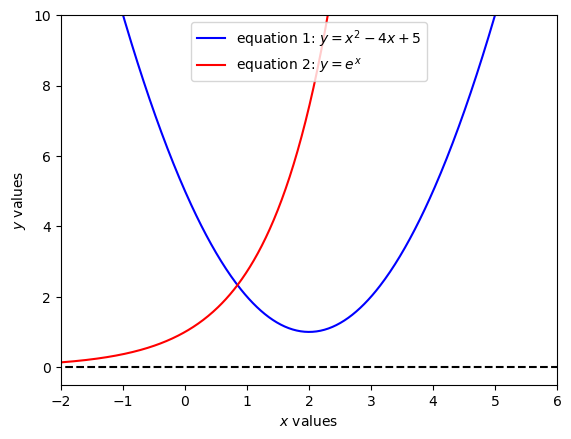

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def eq1_y_SciPyRoot_examp1(x):
    """
    This function uses the function of x and y in the first equation of example 1
    in the SciPy Chapter, Root finding section to take a value for x and deliver
    the corresponding value for y
    """
    y = (x ** 2) - (4 * x) + 5

    return y


def eq2_y_SciPyRoot_examp1(x):
    """
    This function uses the function of x and y in the second equation of example 1
    in the SciPy Chapter, Root finding section to take a value for x and deliver
    the corresponding value for y
    """
    y = np.exp(x)

    return y


xmin = -2
xmax = 6
xvals = np.linspace(xmin, xmax, 500)
y1vals = eq1_y_SciPyRoot_examp1(xvals)
y2vals = eq2_y_SciPyRoot_examp1(xvals)
plt.plot(xvals, y1vals, color='blue', label=r"equation 1: $y=x^2 - 4x + 5$")
plt.plot(xvals, y2vals, color='red', label=r"equation 2: $y=e^x$")
plt.hlines([0], -3, 7, colors=["black"], linestyles=["dashed"])
plt.xlim(xmin, xmax)
plt.ylim(-0.5, 10)
plt.xlabel(r"$x$ values")
plt.ylabel(r"$y$ values")
plt.legend()

plt.show()

```{figure} ../images/SciPy/root_examp1.png
:height: 500px
:name: FigScipyRoot_examp1

Solution to two nonlinear functions in $x$ and $y$
```

We can now use SciPy's root finder [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) to find the solution to equations {eq}`EqSciPyRootEx1a` and {eq}`EqSciPyRootEx1b`.

Note first some properties of the theory or the functions in the system of equations. Although equation {eq}`EqSciPyRootEx1a` is defined for any $x$ in the real line $x\in(-\infty,\infty)$, it is only defined for $y$ weakly greater than one $y\geq 1$. However, the left-hand-side of {eq}`EqSciPyRootEx1a` is defined for any values of $x$ and $y$ on the real line. Similarly, equation {eq}`EqSciPyRootEx1b` is defined for any $x$ in the real line $x\in(-\infty,\infty)$, it is only defined for strictly positive $y>0$. But any values for $x$ and $y$ on the real line are defined for the left-hand-side of {eq}`EqSciPyRootEx1b`.

The following Python code block executes a [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) root finder to find the solution to equations {eq}`EqSciPyRootEx1a` and {eq}`EqSciPyRootEx1b`. The key components to a Scipy root finder are
* An error function (see `errfunc_SciPyRoot_examp1` function below) that takes an arbitrary vector of input variable values $x$ and outputs the corresponding right-hand-side errors associated with that vector as shown in the right-hand-side of {eq}`EqSciPy_ZeroFuncErr`.
* An initial guess $x_{init}$ (see `init_guess_xy` list below) that does not violate any of the properties of the equations of the problem.

The root finder algorithm then iterates on values of the $x$ vector starting at the initial guess $x_{init}$ that reduce the error values that are right-hand-side of {eq}`EqSciPy_ZeroFuncErr` which is the the output of `errfunc_SciPyRoot_examp1` function below.

In [2]:
import scipy.optimize as opt


def f1_SciPyRoot_examp1(x, y):
    """
    This is the evaluation of the right-hand-side of the first equation of example 1
    in the SciPy Chapter, Root finding section. We can interpret this value as an
    error because it need not equal zero in general.
    """
    error1 = (x ** 2) - (4 * x) + 5 - y

    return error1


def f2_SciPyRoot_examp1(x, y):
    """
    This is the evaluation of the right-hand-side of the second equation of example 1
    in the SciPy Chapter, Root finding section. We can interpret this value as an
    error because it need not equal zero in general.
    """
    error2 = np.exp(x) - y

    return error2


def errfunc_SciPyRoot_examp1(xy_list):
    """
    This function takes as arguments
    """
    x, y = xy_list
    error_func1 = f1_SciPyRoot_examp1(x, y)
    error_func2 = f2_SciPyRoot_examp1(x, y)
    errors_list = [error_func1, error_func2]

    return errors_list


init_guess_xy = [0, 0]
solution = opt.root(errfunc_SciPyRoot_examp1, init_guess_xy)

print(solution)
print("")
print("The solution for (x, y) is:", solution.x)
print("")
print("The error values for eq1 and eq2 at the solution are:", solution.fun)

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.235e-13 -1.017e-13]
       x: [ 8.463e-01  2.331e+00]
    nfev: 10
    fjac: [[-8.332e-01  5.529e-01]
           [-5.529e-01 -8.332e-01]]
       r: [ 3.416e+00  2.714e-01  1.357e+00]
     qtf: [-1.145e-10 -3.728e-10]

The solution for (x, y) is: [0.84630378 2.33101497]

The error values for eq1 and eq2 at the solution are: [-1.23456800e-13 -1.01696429e-13]


As we saw in {numref}`Figure %s <FigScipyRoot_examp1>`, the solution is $(\hat{x},\hat{y})=(0.846, 2.331)$ and the zero functions are solved to $1e-12$ precision. {numref}`ExerScipy-root-lin` has you test the linear algebra solution to a system of linear equations to the SciPy root finder solution.


(SecSciPyRoot_examp2)=
#### OG-Core equations example

In the `OG-Core` macroeconomic model, every age-$s$ individual in the model chooses how much to consume $c_{s,t}$, save $b_{s+1,t+1}$, and work $n_{s,t}$ in each period $t$.[^OG-Core-Indiv] In this model, each individual's decision problem can be reduced to choosing consumption $c_{s,t}$ and labor supply $n_{s,t}$ each period. In {numref}`ExerScipy-root_labor` and {numref}`ExerScipy-root_save`, you will use SciPy's root finder to solve for optimal labor supply decisions for three different households and optimal consumption decisions over the lifetime of a household, respectively.


(SecSciPyMin)=
## Minimization

Minimization problems are a more general type of problem than root finding problems. Any root finding problem can be reformulated as a minimization problem. But it is not the case that any minimization problem can be reformulated as a root finding problem. Furthermore, if a minimization problem can be reformulated as a root finding problem, it is often much faster to compute the root finding problem. But the minimization problem allows for more generality and often more robustness.

{numref}`ExerSciPy-root-min` has you compute the solution to a problem using minimization and root finding, respectively, and to compare the corresponding computation times. One of our favorite books and resources on the mathematics behind minimization problems is {cite}`HumpherysJarvis:2020` (section IV, pp.519-760).


(SecSciPyInterp)=
## Interpolation


(SecSciPyExercises)=
## Exercises

```{exercise-start} Linear algebra vs. root finder
:label: ExerScipy-root-lin
:class: green
```
Define an exactly identified linear system of three equations and three unknown variables $R=R^*=3=K$.
\begin{equation*}
  \begin{split}
    3x_1 +  x_2 - 9x_3 &= 0.0 \\
    -4x_1 + 6x_2 + 2x_3 &= 0.5 \\
    5x_1 - 8x_2 + 7x_3 &= -2.5
  \end{split}
\end{equation*}
or
\begin{equation*}
  \begin{bmatrix}
    3 & 1 & -9 \\
    -4 & 6 & 2 \\
    5 & -8 & 7 \\
  \end{bmatrix}
  \begin{bmatrix}
    x_1 \\ x_2 \\ x_3
  \end{bmatrix} =
  \begin{bmatrix}
    0.0 \\ 0.5 \\ -2.5
  \end{bmatrix}
\end{equation*}
Use linear algebra matrix inversion to solve for the solution $\hat{x}\equiv[\hat{x}_1,\hat{x}_2,\hat{x}_3]^T$ to the equation (i.e., $\hat{x} = A^{-1}b$). Next, use `scipy.optimize.root` to solve for the same solution. Verify that both sets of answers are close to the nearest $1e-8$.
```{exercise-end}
```

```{exercise-start}
:label: ExerScipy-root_labor
:class: green
```
In a three-period-lived agent overlapping generations model, let $s=\{1,2,3\}$ represent the age of an individual. In every period, a young agent $s=1$, a middle-aged agent $s=2$, and an old agent $s=3$ exist in the economy together. The consumption-labor Euler equation for each age-$s$ agent represents the optimal labor supply decision $n_s$ that balances benefit of extra consumption from labor income with the disutility of working, given the consumption amount $c_s$ and the current wage $w$.[^EvansPhillips]
\begin{equation*}
  \frac{w}{c_s} = (n_s)^\frac{1}{2}\left[1 - (n_s)^\frac{3}{2}\right]^{-\frac{1}{3}} \quad\text{for}\quad s=1,2,3
\end{equation*}

Let the wage be one $w=1$ and let the consumption of each aged individual be $[c_1,c_2,c_3]=[1.0, 2.0, 1.5]$. The system of three equations and three unknowns $[n_1,n_2,n_3]$ is therefore the following.
\begin{equation*}
  \begin{split}
    1 &= (n_1)^\frac{1}{2}\left[1 - (n_1)^\frac{3}{2}\right]^{-\frac{1}{3}} \\
    \frac{1}{2} &= (n_2)^\frac{1}{2}\left[1 - (n_2)^\frac{3}{2}\right]^{-\frac{1}{3}} \\
    \frac{1}{1.5} &= (n_3)^\frac{1}{2}\left[1 - (n_3)^\frac{3}{2}\right]^{-\frac{1}{3}}
  \end{split}
\end{equation*}
Use SciPy's root finder to solve for each age agent's optimal labor supply decision $[\hat{n}_1,\hat{n}_2,\hat{n}_3]$. Each equation is independently identified in that each function $f_s(n_s)$ is only a function of one variable. But solve for all three variables simultaneously.
```{exercise-end}
```

```{exercise-start}
:label: ExerScipy-root_save
:class: green
```
In a four-period-lived agent overlapping generations model, let $s=\{1,2,3,4\}$ represent the age of an individual. Assume that labor supply over the lifetime of an individual is exogenously supplied. Let $n_s$ be the amount of labor supplied by the age-$s$ individual in any period $t$. Then assume the lifetime labor supply of an individual is exogenously $(n_1,n_2,n_3,n_4)=(0.3, 0.5, 0.6, 0.2)$. The consumption-savings Euler equation for each of the youngest three age-$s$ agents represents the optimal savings decision $b_{s+1,t+1}$ that balances benefit of consumption in the current period $c_t$ with discounted consumption in the next period $c_{t+1}$, given preference parameter values and exogenous labor supply $n_s$. The oldest agent $s=4$ has no savings decision because they die at the end of the period.
\begin{equation*}
  \begin{split}
    &(c_{s,t})^{-1.5} = \beta\left(1 + r_{t+1}\right)(c_{s+1,t+1})^{-1.5} \quad\text{for}\quad s=1,2,3 \\
    \text{where}\quad &c_{s,t} = w_t n_s + (1 + r_t)b_{s,t} - b_{s+1,t+1} \quad\text{and}\quad b_{1,t}, b_{5,t}=0
  \end{split}
\end{equation*}
If we plug the budget constraint from the second line of the equation above into each of the Euler equations in the first line, and assume $\beta = 0.8$, constant wages $w_t=1$ for all $t$, constant interest rates $r_t=0.1$ for all $t$, and exogenous labor supply over the lifetime is $(n_1,n_2,n_3,n_4)=(0.3, 0.5, 0.6, 0.2)$, we get a system of three Euler equations in three unknown optimal savings amounts $(b_{2,t+1}, b_{3,t+2}, b_{4,t+3})$ over the lifetime of the individual.
\begin{equation*}
  \begin{split}
    \left[n_1 - b_{2,t+1}\right]^{-1.5} &= 0.8(1.1)\left[n_2 + 1.1b_{2,t+1} - b_{3,t+2}\right]^{-1.5} \\
    \left[n_2 + 1.1b_{2,t+1} - b_{3,t+2}\right]^{-1.5} &= 0.8(1.1)\left[n_3 + 1.1b_{3,t+2} - b_{4,t+3}\right]^{-1.5} \\
    \left[n_3 + 1.1b_{3,t+2} - b_{4,t+3}\right]^{-1.5} &= 0.8(1.1)\left[n_4 + 1.1b_{4,t+3}\right]^{-1.5}
  \end{split}
\end{equation*}
Use SciPy's root finder to solve for the three optimal lifetime savings amounts $(\hat{b}_{2,t+1},\hat{b}_{3,t+2},\hat{b}_{4,t+3})$. Plug those values back into the budget constraint $c_{s,t}= w_t n_s + (1 + r_t)b_{s,t} - b_{s+1,t+1}$ given $b_{1,t}, b_{5,t}=0$ to solve for optimal consumption values $(\hat{c}_{1,t},\hat{c}_{2,t+1},\hat{c}_{3,t+2}, \hat{c}_{4,t+3})$.
```{exercise-end}
```

```{exercise-start}
:label: ExerScipy-BM72_ss
:class: green
```
{cite}`BrockMirman:1972` is a simple two-period-lived overlapping generations model, the stochastic equilibrium of which is characterized by six dynamic equations (equations in which the variables are changing over time). The deterministic steady-state of the model is characterized by the variables reaching constant values that do not change over time. The deterministic steady state of the {cite}`BrockMirman:1972` is characterized by the following five equations and five unknown variables $(c, k, y, w, r)$,
\begin{equation*}
  \begin{split}
    \frac{1}{c} &= \beta\frac{r}{c} \\
    c &= (1+r)k + w \\
    w &= (1-\alpha)k^\alpha \\
    r &= \alpha k^{\alpha-1} \\
    y &= k^\alpha
  \end{split}
\end{equation*}
where $c$ is consumption, $k$ is capital investment/savings, $y$ is GDP, $w$ is the wage, and $r$ is the interest rate. Assume $\beta=0.7$ and $\alpha=0.35$. Solve for the steady-state variables $(c, k, y, w, r)$ using the above five equations and SciPy's root finder.

```{exercise-end}
```

```{exercise-start} Root finder vs. minimizer
:label: ExerScipy-root-min
:class: green
```
Characterize a minimization problem that can also be solved using a root finder. Write code to solve the problem both ways. Record the respective computation times of both solution methods. How does the minimization method computation time compare to the root finder computation time?
```{exercise-end}
```

```{exercise-start}
:label: ExerScipy-min_constraint
:class: green
```
Use `scipy.optimize.minimize` to minimize the function $f(x,y)=x^2y$ on the unit circle, i.e., subject to $x^2 + y^2 = 1$.  Use the `constraints` keyword argument to specify the constraint.  What is the minimum value of $f(x,y)$ subject to this constraint?  Can you confirm this by doing the problem by hand using calculus?
```{exercise-end}
```

```{exercise-start}
:label: ExerScipy-interp
:class: green
```
Consider the following `x` and `y` vectors, which represent some functional relationship, `y=f(x)`:

```python
x = np.array([
  5.15151515,   3.13131313,  -6.36363636,   9.39393939,
  -1.31313131,   0.50505051,  -0.50505051,  -2.12121212,
  -7.37373737,  -0.1010101 ,   3.73737374,   2.52525253,
  2.12121212, -10.        ,  -9.5959596 ,   6.36363636,
  3.53535354,  -5.75757576,  -4.34343434,  -8.18181818,
  8.18181818,  -3.13131313,   2.92929293,   4.74747475,
  -6.56565657,  -0.3030303 ,  -2.32323232,   1.11111111,
  -7.17171717,  -5.55555556,  -3.73737374,  -4.14141414,
  8.38383838,   4.94949495,   0.70707071,  -3.33333333,
  6.96969697,  -2.72727273,   5.55555556,  -7.77777778])
```

```python
y = np.array([
  -0.90512352,  0.01027934, -0.0803643 ,  0.03083368, -0.96698762,
  0.48385164, -0.48385164, -0.85230712, -0.8868821 , -0.10083842,
  -0.56115544,  0.57805259,  0.85230712,  0.54402111,  0.17034683,
  0.0803643 , -0.38366419,  0.50174037,  0.93270486, -0.94674118,
  0.94674118, -0.01027934,  0.21070855, -0.99938456, -0.27872982,
  -0.2984138 , -0.73002623,  0.8961922 , -0.77614685,  0.66510151,
  0.56115544,  0.84137452,  0.86287948, -0.97202182,  0.64960951,
  0.19056796,  0.63384295, -0.40256749, -0.66510151, -0.99709789])
```

Create a scatter plot of `x` and `y` to see their relationship.  Is it hard to tell what this function looks like?

Now use `scipy.interpolate.interp1d` to interpolate the function $f(x)$ using `x` and `y`.  Use the keyword argument `kind='cubic'` to specify that you want to use cubic splines to interpolate the function and `fill_value=extrapolate` to note that you want to extrapolate beyond the values in the original `x` vector.

Create a plot of this interpolated function over the domain $x \in [-10, 10]$.  Can you now see what this function is?
```{exercise-end}
```


(SecSciPyFootnotes)=
## Footnotes

The footnotes from this chapter.

[^SciPy]: The website for Python's SciPy package is https://scipy.org.

[^SciPyJuddMethods]: See {cite}`Judd:1998` (Chap. 5) for a discussion of solution methods to nonlinear equations.

[^OG-Core-Indiv]: See `OG-Core` model documentation theory chapter "[Households](https://pslmodels.github.io/OG-Core/content/theory/households.html)".

[^EvansPhillips]: This Euler equation corresponds to a simple model in which the coefficient of relative risk aversion is unity $\sigma=1$ in a CRRA utility function and the disutility of labor supply is characterized by the functional form proposed in {cite}`EvansPhillips:2017`, with $b=1$, $\nu=1.5$, and maximum labor supply $l=1$.